In [1]:
import deeplake
from PIL import Image
import numpy as np
import os, time
import random
import torch
from torchvision import transforms, models
import getpass

# #dataset hosted by activeloop 
ds = deeplake.load('hub://activeloop/office-home-domain-adaptation')

#summary of dataset tensors 
ds.summary()

# ds_train, ds_test = ds.random_split([0.8, 0.2])

# print(f"Length of train_view is {len(ds_train)}")
# print(f"Length of val_view is {len(ds_test)}")

# Filter the dataset to include only samples belonging to the selected category
filtered_indices = ds['domain_categories'][:, 0] == 0
filtered_dataset = ds[filtered_indices]

print(f"Length of train_view is {len(filtered_dataset)}")

filtered_dataset.summary()


# Connect to the training and testing datasets
# ds_train = deeplake.load('hub://activeloop/fashion-mnist-train')
# ds_test = deeplake.load('hub://activeloop/fashion-mnist-test')
# ds_train.summary()

/home/robbie/.local/lib/python3.8/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.5) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
\

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/office-home-domain-adaptation



/

hub://activeloop/office-home-domain-adaptation loaded successfully.

Dataset(path='hub://activeloop/office-home-domain-adaptation', read_only=True, tensors=['images', 'domain_categories', 'domain_objects'])

      tensor           htype                shape              dtype  compression
      -------         -------              -------            -------  ------- 
      images           image     (15588, 4:6500, 18:6000, 3)   uint8    jpeg   
 domain_categories  class_label          (15588, 1)           uint32    None   
  domain_objects    class_label          (15588, 1)           uint32    None   


In [2]:
#function to show images 
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F



def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        # img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(801, 768, 3)


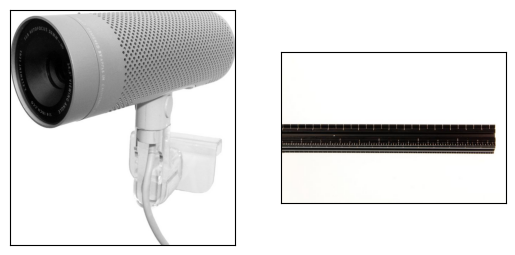

In [3]:

# Indexing
img = ds_train.images[0:2].numpy(aslist=True)              # Fetch the 1st image and return a NumPy array

print(img[0].shape)
show(img)

# labels = ds.labels[0].numpy(aslist=True)  


#might need to use compression on the data 


In [4]:
#transformation function 

tform = transforms.Compose([
    # transforms.RandomRotation(20),  # Image augmentation
    transforms.ToTensor(),  # Converts image to tensor
    transforms.Normalize([0.5], [0.5]),  # Normalize tensor values
])


In [12]:
batch_size = 32 #we set the batch size depends on gpu/cpu processing capabilities 32 should be fine (pretty small)

# Since torchvision transforms expect PIL images, we use the 'pil' decode_method for the 'images' tensor. This is much faster than running ToPILImage inside the transform
train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, transform = {'images': tform, 'domain_categories': None}, batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'domain_categories': None}, batch_size = batch_size, decode_method = {'images': 'pil'})

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #doubt anyone got cuda but if you do its gonna be way quicker :)
print(device)

cpu


In [10]:
# Use a pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Convert model to grayscale
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Update the fully connected layer based on the number of classes in the dataset
model.fc = torch.nn.Linear(model.fc.in_features, len(ds_train.labels.info.class_names))

model.to(device)

# Specity the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

/home/robbie/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/robbie/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: '<class 'deeplake.core.dataset.deeplake_cloud_dataset.DeepLakeCloudDataset'>' object has no attribute 'labels'

In [49]:
def train_one_epoch(model, optimizer, data_loader, device):

    model.train()

    # Zero the performance stats for each epoch
    running_loss = 0.0
    start_time = time.time()
    total = 0
    correct = 0
    
    for i, data in enumerate(data_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['images']
        labels = torch.squeeze(data['labels'])

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        # Print performance statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every 10 batches
            batch_time = time.time()
            speed = (i+1)/(batch_time-start_time)
            print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                  (i, running_loss, speed, accuracy))

            running_loss = 0.0
            total = 0
            correct = 0

    
def test_model(model, data_loader):

    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))

In [50]:
num_epochs = 3
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, optimizer, train_loader, device)

    test_model(model, test_loader)

print('Finished Training')

------------------ Training Epoch 1 ------------------
[    0] loss: 2.620, speed: 0.01, accuracy: 9.38 %
[   10] loss: 23.832, speed: 0.06, accuracy: 13.44 %
[   20] loss: 20.791, speed: 0.12, accuracy: 27.81 %
[   30] loss: 17.647, speed: 0.18, accuracy: 41.56 %
[   40] loss: 17.256, speed: 0.24, accuracy: 43.12 %
[   50] loss: 15.447, speed: 0.29, accuracy: 50.62 %
[   60] loss: 14.270, speed: 0.35, accuracy: 51.25 %
[   70] loss: 13.710, speed: 0.40, accuracy: 54.38 %
[   80] loss: 13.619, speed: 0.46, accuracy: 55.62 %
[   90] loss: 12.439, speed: 0.51, accuracy: 59.69 %
[  100] loss: 12.627, speed: 0.57, accuracy: 57.50 %
[  110] loss: 10.677, speed: 0.62, accuracy: 62.19 %
[  120] loss: 11.744, speed: 0.67, accuracy: 59.06 %
[  130] loss: 10.941, speed: 0.72, accuracy: 64.06 %
[  140] loss: 10.335, speed: 0.78, accuracy: 61.56 %
[  150] loss: 10.619, speed: 0.83, accuracy: 64.06 %
[  160] loss: 10.043, speed: 0.88, accuracy: 62.50 %
[  170] loss: 10.309, speed: 0.93, accuracy: 6

KeyboardInterrupt: 